# TinyML

- https://www.tensorflow.org/lite

  > tensorflow lite 공식문서

- https://www.udacity.com/course/intro-to-tensorflow-lite--ud190

  > udacity free course

## work flow

1. Collect Datasets

2. Train

3. Convert the Model

   > Tenworflow Lite Converter로 변환

4. Inference(Prediction)



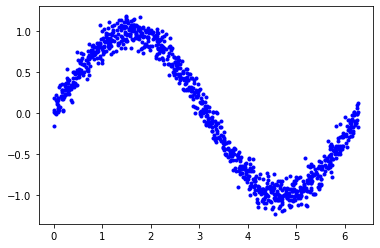

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

# Generate Data
SAMPLES = 1000
SEED = 1337
np.random.seed(SEED) 
tf.random.set_seed(SEED)

# Generate a uniformly distributed set of random numbers in the range from 
# 0 to 2π, which covers a complete sine wave oscillation 
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# Shuffle the values to guarantee they're not in order 
np.random.shuffle(x_values)

# Calculate the corresponding sine values 
y_values = np.sin(x_values)

# Plot our data. The 'b.' argument tells the library to print blue dots. 
# Add a small random number to each y value 
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data 
plt.plot(x_values, y_values, 'b.') 
plt.show() 

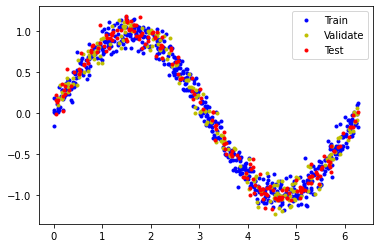

In [2]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20% # will be used for validation. Calculate the indices of each section. 
TRAIN_SPLIT =  int(0.6 * SAMPLES) 
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)
# Use np.split to chop our data into three parts. 
# The second argument to np.split is an array of indices where the data will be 
# split. We provide two indices, so the data will be divided into three chunks. 
x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT]) 
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])
# Double check that our splits add up correctly 
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors: 
plt.plot(x_train, y_train, 'b.', label="Train") 
plt.plot(x_validate, y_validate, 'y.', label="Validate") 
plt.plot(x_test, y_test, 'r.', label="Test") 
plt.legend() 
plt.show() 

In [9]:
from tensorflow.keras import layers 
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x_train, y_train, epochs=600, batch_size=16, validation_data = (x_validate, y_validate))

Epoch 1/600
38/38 [==============================] - 0s 6ms/step - loss: 0.3878 - mae: 0.5369 - val_loss: 0.3631 - val_mae: 0.5215
Epoch 2/600
38/38 [==============================] - 0s 2ms/step - loss: 0.3163 - mae: 0.4900 - val_loss: 0.3097 - val_mae: 0.4740
Epoch 3/600
38/38 [==============================] - 0s 2ms/step - loss: 0.2656 - mae: 0.4497 - val_loss: 0.2580 - val_mae: 0.4374
Epoch 4/600
38/38 [==============================] - 0s 2ms/step - loss: 0.2289 - mae: 0.4178 - val_loss: 0.2239 - val_mae: 0.4079
Epoch 5/600
38/38 [==============================] - 0s 2ms/step - loss: 0.2045 - mae: 0.3960 - val_loss: 0.1986 - val_mae: 0.3841
Epoch 6/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1874 - mae: 0.3768 - val_loss: 0.1915 - val_mae: 0.3689
Epoch 7/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1805 - mae: 0.3666 - val_loss: 0.1872 - val_mae: 0.3722
Epoch 8/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1761 - m

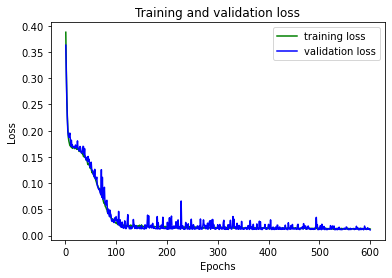

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'g', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend() 
plt.show()

7/7 [==============================] - 0s 998us/step - loss: 0.0089 - mae: 0.0739


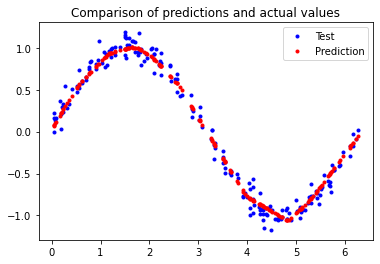

In [12]:
loss = model.evaluate(x_test, y_test)
predictions = model.predict(x_test)

plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label="Test") 
plt.plot(x_test, predictions,'r.',label='Prediction')
plt.legend()
plt.show()

### Converting the model for tensorflow lite
- optimization : quantization
- 32-bit floating-point numbers -> 8-bit integers


In [18]:
# Convert 방법1
# Convert the model to the TensorFlow Lite format without quantization 

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#save the model to disk
open("sine_model.tflite","wb").write(tflite_model)

# Convert 방법2
# Convert the model to the TensorFlow Lite format with quantization 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define a generator function that provides our test data's x values 
def representative_dataset_generator():  
    for value in x_test:
        # Each scalar value must be inside of a 2D array that is wrapped in a list    
        yield [np.array(value, dtype=np.float32, ndmin=2)] 
        
converter.representitive_dataset = representative_dataset_generator

tflite_model = converter.convert()

open("sine_model_quantized.tflite","wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\dayou\AppData\Local\Temp\tmpskusiut8\assets
INFO:tensorflow:Assets written to: C:\Users\dayou\AppData\Local\Temp\tmp9xtrmqhz\assets


INFO:tensorflow:Assets written to: C:\Users\dayou\AppData\Local\Temp\tmp9xtrmqhz\assets


2928

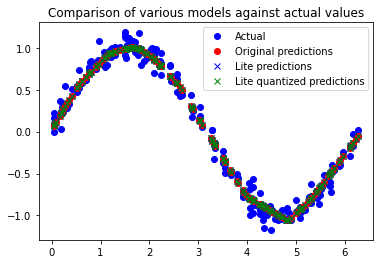

In [25]:
# Instantiate an interpreter for each model






sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

# Allocate memory
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

# get indexes 
sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model_quantized.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0] ["index"] 
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]["index"]

sine_model_predictions =[]
sine_model_quantized_predictions = []

# run intepreter
for x_value in x_test:
    #create a 2D tensor wrapping the current x value
    x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
    # Write the value to the input tensor
    sine_model.set_tensor(sine_model_input_index, x_value_tensor)
    # run inference
    sine_model.invoke()
    sine_model_predictions.append(sine_model.get_tensor(sine_model_output_index)[0])
    
    sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)
    sine_model_quantized.invoke()
    sine_model_quantized_predictions.append(sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])
    
    
plt.clf()
plt.title('Comparison of various models against actual values') 
plt.plot(x_test, y_test, 'bo', label='Actual')
plt.plot(x_test, predictions, 'ro', label='Original predictions') 
plt.plot(x_test, sine_model_predictions, 'bx', label='Lite predictions') 
plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions') 
plt.legend() 
plt.show() 